## t-SNE of the last layer before classication head

In [1]:
from fileinput import filename
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


import torch
from torchvision.models import resnet50,densenet121
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score

from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from src.data.pytorch_dataset import MaskingDataset
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor

import shap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/theo/miniconda3/envs/mmc_masking/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## t-SNE


Full

NoLung

NoLungBB

OnlyLung

OnlyLungBB


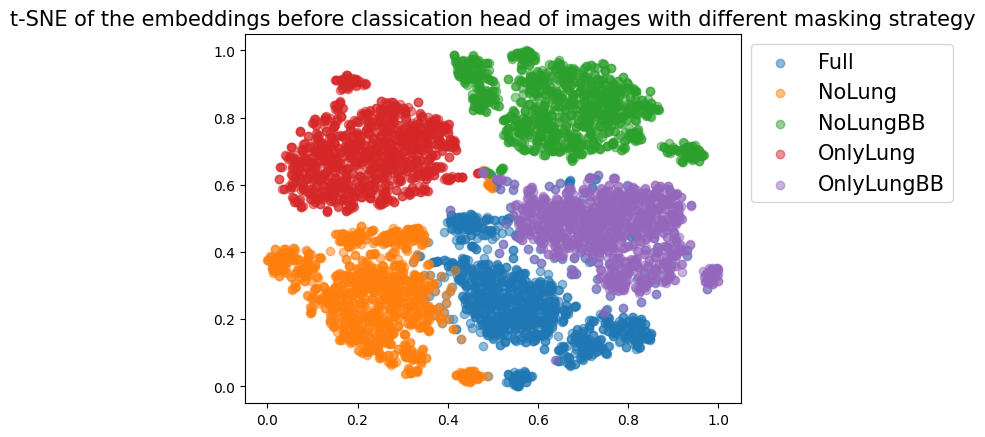

In [2]:
def plot_tsne():
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    model_name="NormalDataset"
    
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed")
    testing_data = MaskingDataset(data_dir="../data/processed")

    #Split the dataset into training/testing splits
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 1907)
    train_eval_split = splitter.split(training_data.img_labels, groups=training_data.img_labels['PatientID'])
    train_idx, test_idx = next(train_eval_split)
    training_data.img_labels = training_data.img_labels.iloc[train_idx].reset_index(drop=True)
    training_data.img_paths = np.array(training_data.img_paths)[train_idx]
    training_data.roi_paths = np.array(training_data.roi_paths)[train_idx]

    testing_data.img_labels = testing_data.img_labels.iloc[test_idx].reset_index(drop=True)
    testing_data.img_paths = np.array(testing_data.img_paths)[test_idx]
    testing_data.roi_paths = np.array(testing_data.roi_paths)[test_idx]
    

    #Create k-fold for train/val
    group_kfold = GroupKFold(n_splits=NB_FOLDS)
    
    valid_params={
        "Full":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        "NoLung":{"masking_spread":0,"inverse_roi":False,"bounding_box":False},
        "NoLungBB":{"masking_spread":0,"inverse_roi":False,"bounding_box":True},
        "OnlyLung":{"masking_spread":0,"inverse_roi":True,"bounding_box":False},
        "OnlyLungBB":{"masking_spread":0,"inverse_roi":True,"bounding_box":True},

    }
    
    models_flatten_output = []
    label_masking = []
    labels_dataset = []
    for masking_param in valid_params:
        print(f"\n{masking_param}")
        for i, (train_index,val_index) in enumerate(group_kfold.split(training_data.img_labels, groups= training_data.img_labels['PatientID'])):        
            val_data = MaskingDataset(data_dir="../data/processed",**valid_params[masking_param])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            return_nodes = {
                "classifier.0": "flatten"
            }
            model = create_feature_extractor(model,return_nodes)
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(valid_dataloader, 0):
                    inputs, labels = data
                    inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                    outputs = model(inputs)
                    models_flatten_output.extend(outputs["flatten"].detach().cpu().tolist())
                    label_masking += len(inputs)*[masking_param]  
                    labels_dataset += labels
            break
    models_flatten_output = np.array(models_flatten_output)
    
    #Taken from https://learnopencv.com/t-sne-for-feature-visualization/
    tsne = TSNE(n_components=2,perplexity=10).fit_transform(np.array(models_flatten_output))
    # scale and move the coordinates so they fit [0; 1] range
    def scale_to_01_range(x):
        # compute the distribution range
        value_range = (np.max(x) - np.min(x))
     
        # move the distribution so that it starts from zero
        # by extracting the minimal value from all its values
        starts_from_zero = x - np.min(x)
     
        # make the distribution fit [0; 1] by dividing by its range
        return starts_from_zero / value_range
     
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]
     
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)


    #Plot divided by masking strategy
    plt.figure()
    for masking_param in valid_params:
        indices = [j for j, l in enumerate(label_masking) if l == masking_param]
        # extract the coordinates of the points of the current masking
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        plt.scatter(current_tx,current_ty,label=masking_param,alpha=0.5)
    plt.title(f"t-SNE of the embeddings before classication head of images with different masking strategy",size=15)
    plt.legend(bbox_to_anchor=(1,1),fontsize=15)
    plt.show()
    
    return
        

def main():
    plot_tsne()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()

## Cosine similarity

In [4]:
from fileinput import filename
from operator import index
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os.path


import torch
from torchvision.models import resnet50,densenet121
from torch.nn.functional import sigmoid
from sklearn.metrics import roc_auc_score,f1_score

from torch.utils.data import DataLoader
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from src.data.pytorch_dataset import MaskingDataset
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
from scipy.linalg import sqrtm
from scipy.spatial.distance import cosine

import shap
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def get_embedding(model_name,valid_params):
    NB_FOLDS = int(os.environ.get("NB_FOLDS"))
    BATCH_SIZE = int(os.environ.get("BATCH_SIZE"))
    CLASSES = os.environ.get("CLASSES").split(",")
    
    #Load the base dataset
    training_data = MaskingDataset(data_dir="../data/processed")
    testing_data = MaskingDataset(data_dir="../data/processed")

    #Split the dataset into training/testing splits
    splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state = 1907)
    train_eval_split = splitter.split(training_data.img_labels, groups=training_data.img_labels['PatientID'])
    train_idx, test_idx = next(train_eval_split)
    training_data.img_labels = training_data.img_labels.iloc[train_idx].reset_index(drop=True)
    training_data.img_paths = np.array(training_data.img_paths)[train_idx]
    training_data.roi_paths = np.array(training_data.roi_paths)[train_idx]

    testing_data.img_labels = testing_data.img_labels.iloc[test_idx].reset_index(drop=True)
    testing_data.img_paths = np.array(testing_data.img_paths)[test_idx]
    testing_data.roi_paths = np.array(testing_data.roi_paths)[test_idx]
    

    #Create k-fold for train/val
    group_kfold = GroupKFold(n_splits=NB_FOLDS)
    
    
    models_flatten_output = {
        masking_param:[] for masking_param in valid_params
    }
    
    for masking_param in valid_params:
        print(f"\n{masking_param}")
        for i, (train_index,val_index) in enumerate(group_kfold.split(training_data.img_labels, groups= training_data.img_labels['PatientID'])):        
            val_data = MaskingDataset(data_dir="../data/processed",**valid_params[masking_param])
            val_data.img_labels = training_data.img_labels.iloc[val_index].reset_index(drop=True)
            val_data.img_paths = np.array(training_data.img_paths)[val_index]
            val_data.roi_paths = np.array(training_data.roi_paths)[val_index]

            valid_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
            
            
            #Define model, loss and optimizer
            model = densenet121(weights='DEFAULT')#Weights pretrained on imagenet_1k
            
            # Freeze every layer except last denseblock and classifier
            for param in model.parameters():
                param.requires_grad = False
            for param in model.features.denseblock4.denselayer16.parameters():
                param.requires_grad = True
           
            kernel_count = model.classifier.in_features
            model.classifier = torch.nn.Sequential(
             torch.nn.Flatten(),
             torch.nn.Linear(kernel_count, len(CLASSES))
            )
            
            try:
                model.load_state_dict(torch.load(f"../models/{model_name}/{model_name}_Fold{i}.pt"))
                model.to(DEVICE)
            except FileNotFoundError as e:
                print("No model saved for fold",i)
                continue
            
            return_nodes = {
                "classifier.0": "flatten"
            }
            model = create_feature_extractor(model,return_nodes)
            model.eval()
            with torch.no_grad():
                labels_dataset = []
                for i, data in enumerate(valid_dataloader, 0):
                    inputs, labels = data
                    inputs,labels = inputs.float().to(DEVICE), torch.Tensor(np.array(labels)).float().to(DEVICE)
                    outputs = model(inputs)
                    models_flatten_output[masking_param].extend(outputs["flatten"].detach().cpu().tolist())
                    labels_dataset += labels
            models_flatten_output[masking_param] = np.array(models_flatten_output[masking_param])
            break
    return models_flatten_output, labels_dataset


def get_similarity():
    model_name="NormalDataset"
    valid_params={
        "NormalDataset":{"masking_spread":None,"inverse_roi":False,"bounding_box":False},
        "NoLungDataset_0":{"masking_spread":0,"inverse_roi":False,"bounding_box":False},
        "OnlyLungDataset_0":{"masking_spread":0,"inverse_roi":True,"bounding_box":False},
        "NoLungDatasetBB_0":{"masking_spread":0,"inverse_roi":False,"bounding_box":True},
        "OnlyLungDatasetBB_0":{"masking_spread":0,"inverse_roi":True,"bounding_box":True},
    }
    CLASSES = os.environ.get("CLASSES").split(",")
    
    models_flatten_output,labels_dataset = get_embedding(model_name,valid_params)


    #Cosine
    no_lung_similarities = []
    only_lung_similarities = []
    no_lungbb_similarities = []
    only_lungbb_similarities = []
    for j in range(len(models_flatten_output["NormalDataset"])):
        normal = models_flatten_output["NormalDataset"][j]
        nolung = models_flatten_output["NoLungDataset_0"][j]
        nolungbb = models_flatten_output["NoLungDatasetBB_0"][j]
        onlylung = models_flatten_output["OnlyLungDataset_0"][j]
        onlylungbb = models_flatten_output["OnlyLungDatasetBB_0"][j]
        no_lung_similarities.append(1- cosine(normal,nolung))
        only_lung_similarities.append(1- cosine(normal,onlylung))
        no_lung_similarities.append(1- cosine(normal,nolung))
        no_lungbb_similarities.append(1- cosine(normal,nolungbb))
        only_lung_similarities.append(1- cosine(normal,onlylung))
        only_lungbb_similarities.append(1- cosine(normal,onlylungbb))
    print("all",np.mean(no_lung_similarities),np.mean(no_lungbb_similarities), np.mean(only_lung_similarities),np.mean(only_lungbb_similarities))

    #Per class
    for i,c in enumerate(CLASSES):
        no_lung_similarities = []
        only_lung_similarities = []
        no_lungbb_similarities = []
        only_lungbb_similarities = []
        class_indices = [j for j, l in enumerate(labels_dataset) if l[i] == 1 ]
        for j in class_indices:
            normal = models_flatten_output["NormalDataset"][j]
            nolung = models_flatten_output["NoLungDataset_0"][j]
            nolungbb = models_flatten_output["NoLungDatasetBB_0"][j]
            onlylung = models_flatten_output["OnlyLungDataset_0"][j]
            onlylungbb = models_flatten_output["OnlyLungDatasetBB_0"][j]

            no_lung_similarities.append(1- cosine(normal,nolung))
            no_lungbb_similarities.append(1- cosine(normal,nolungbb))
            only_lung_similarities.append(1- cosine(normal,onlylung))
            only_lungbb_similarities.append(1- cosine(normal,onlylungbb))
        print(c,np.mean(no_lung_similarities),np.mean(no_lungbb_similarities), np.mean(only_lung_similarities),np.mean(only_lungbb_similarities))

    #For images without one of the condition
    class_indices = [j for j, l in enumerate(labels_dataset) if sum(l) == 0 ]
    for j in class_indices:
        normal = models_flatten_output["NormalDataset"][j]
        nolung = models_flatten_output["NoLungDataset_0"][j]
        nolungbb = models_flatten_output["NoLungDatasetBB_0"][j]
        onlylung = models_flatten_output["OnlyLungDataset_0"][j]
        onlylungbb = models_flatten_output["OnlyLungDatasetBB_0"][j]

        no_lung_similarities.append(1- cosine(normal,nolung))
        no_lungbb_similarities.append(1- cosine(normal,nolungbb))
        only_lung_similarities.append(1- cosine(normal,onlylung))
        only_lungbb_similarities.append(1- cosine(normal,onlylungbb))
    print("normal",np.mean(no_lung_similarities),np.mean(no_lungbb_similarities), np.mean(only_lung_similarities),np.mean(only_lungbb_similarities))

def main():
    get_similarity()

if __name__ == '__main__':
    load_dotenv(find_dotenv())
    main()


NormalDataset

NoLungDataset_0

OnlyLungDataset_0

NoLungDatasetBB_0

OnlyLungDatasetBB_0
all 0.8963381602352909 0.8266666588244572 0.7623353184575995 0.8894384830868614
cardiomegaly 0.9030516517402595 0.8383592437112988 0.7348444914648778 0.8779198178040167
pneumonia 0.8969819805936382 0.8454507594789473 0.7591275890561736 0.8771132408828506
atelectasis 0.8958844609099623 0.8267468360291784 0.7574333182431902 0.8859920355017324
pneumothorax 0.9141595945973116 0.8951744963194241 0.8257178988924111 0.9032418570628907
effusion 0.8992987527510277 0.8430080667633866 0.7360929042073449 0.8712084064059931
normal 0.8957226967911023 0.824923918922166 0.7645146098694049 0.8907592981703671
